In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
import matplotlib
#matplotlib.use('nbagg')
matplotlib.rcParams['figure.max_open_warning'] = 400
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'svg'
#import mpld3
#mpld3.enable_notebook()

## vague simple

In [102]:
!rm  ../files/onde*

In [103]:
name = 'onde'
vext = '.webm'
import os
import numpy as np
import MotionClouds as mc
mc.N_X, mc.N_Y, mc.N_frame = 50, 2, 2048
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
theta, B_theta = 0., np.pi/8.
alpha, sf_0, B_sf, B_V = 1., .02, .1, .05
seed = 1234565
V_X, V_Y = .05, 0.
mc_wave = mc.envelope_gabor(fx, fy, ft, V_X=V_X, V_Y=V_Y, B_V=B_V, 
                            theta=theta, B_theta=B_theta, sf_0=sf_0, B_sf=B_sf, alpha=alpha)
mc.figures(mc_wave, name, vext=vext, seed=seed, do_figs=False)
mc.in_show_video(name)

Saving sequence ../files/onde as a .webm format


""


Saving the corrresponding cloud as a ``nd.array``:

In [104]:
vague_dense = mc.rectif(mc.random_cloud(mc_wave), contrast=1)
print(vague_dense.shape)

(50, 2, 2048)


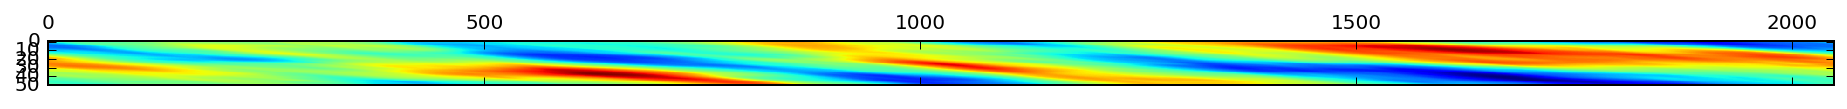

In [105]:
plt.matshow(vague_dense[:, 0, :])

In [106]:
mc.figures(mc_wave, name + '_impulse', seed=seed, impulse=True, do_figs=False)
mc.in_show_video(name + '_impulse')

Saving sequence ../files/onde_impulse as a .webm format


""


In [107]:
vague_solo = mc.rectif(mc.random_cloud(mc_wave, seed=seed, impulse=True), contrast=1)
print(vague_solo.shape, vague_solo.min(), vague_solo.mean(), vague_solo.max())

(50, 2, 2048) 0.368487487441 0.5 1.0


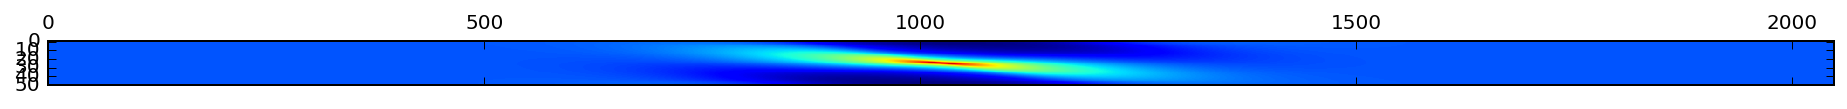

In [108]:
plt.matshow(vague_solo[:, 0, :])

## transforme la vague 2D sur les lames

In [109]:
def vague_animate(z, x_offset=0, y_offset=0, N_lame = 25, t_offset=0, N_steps = 2048):
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from IPython.display import HTML

    fig, ax = plt.subplots(figsize=(15, 3))

    x = np.arange(0, N_lame)        # x-array

    def vague(i):
        return z[x_offset:(x_offset+N_lame), y_offset, t_offset+i]

    def animate(i):
        line.set_ydata(vague(i))  # update the data
        return line,

    #Init only required for blitting to give a clean slate.
    def init():
        line.set_ydata(np.ma.array(x, mask=True))
        return line,

    line,  = ax.plot(x, vague(0))
    ax.set_xlim([0, N_lame-1])
    ax.set_ylim([0, 1])

    anim = animation.FuncAnimation(fig, animate, np.arange(1, N_steps), init_func=init,
        interval=25, blit=True)

    return HTML(anim.to_html5_video())
    

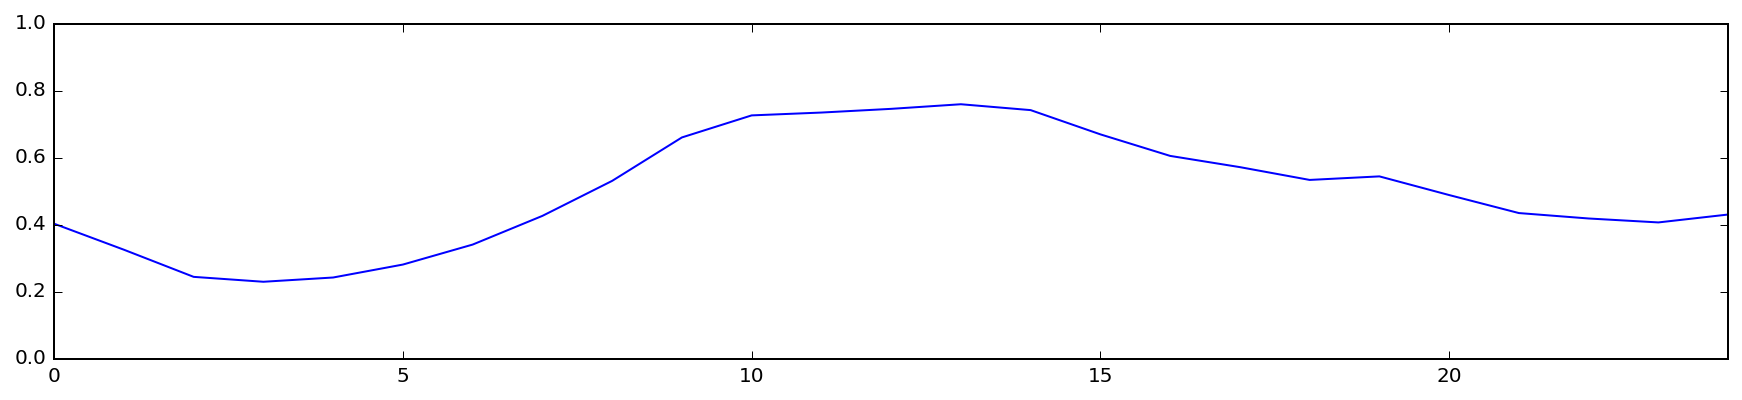

In [110]:
vague_animate(vague_dense[::2, :, :])

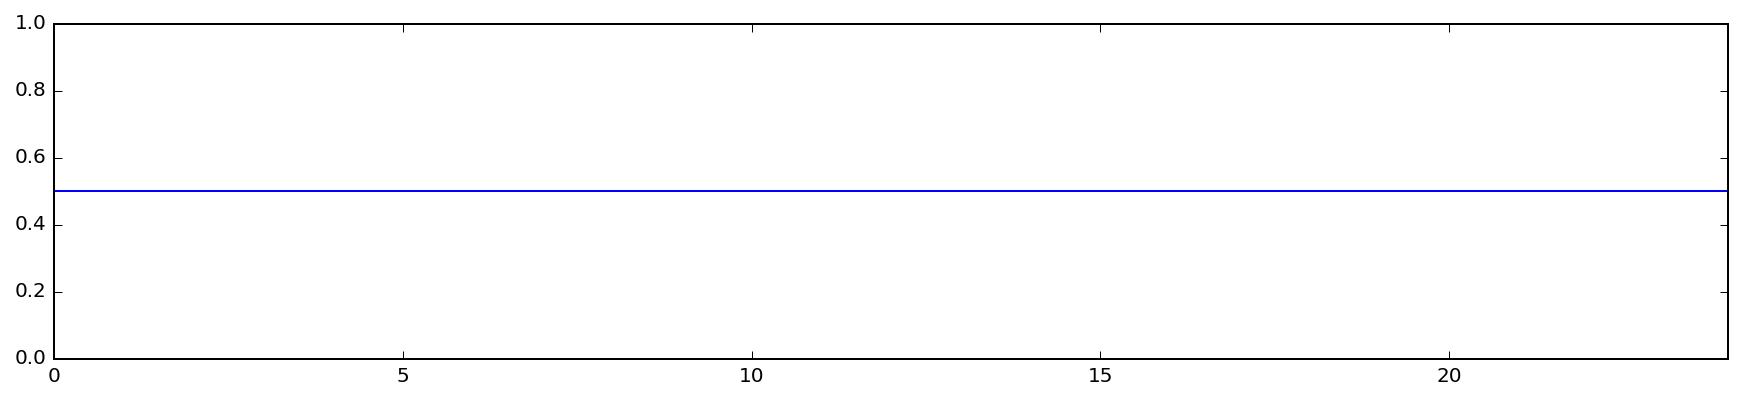

In [111]:
vague_animate(vague_solo, x_offset=vague_solo.shape[0]//2-25//2, y_offset=vague_solo.shape[1]//2, t_offset=0, N_steps = vague_solo.shape[-1])

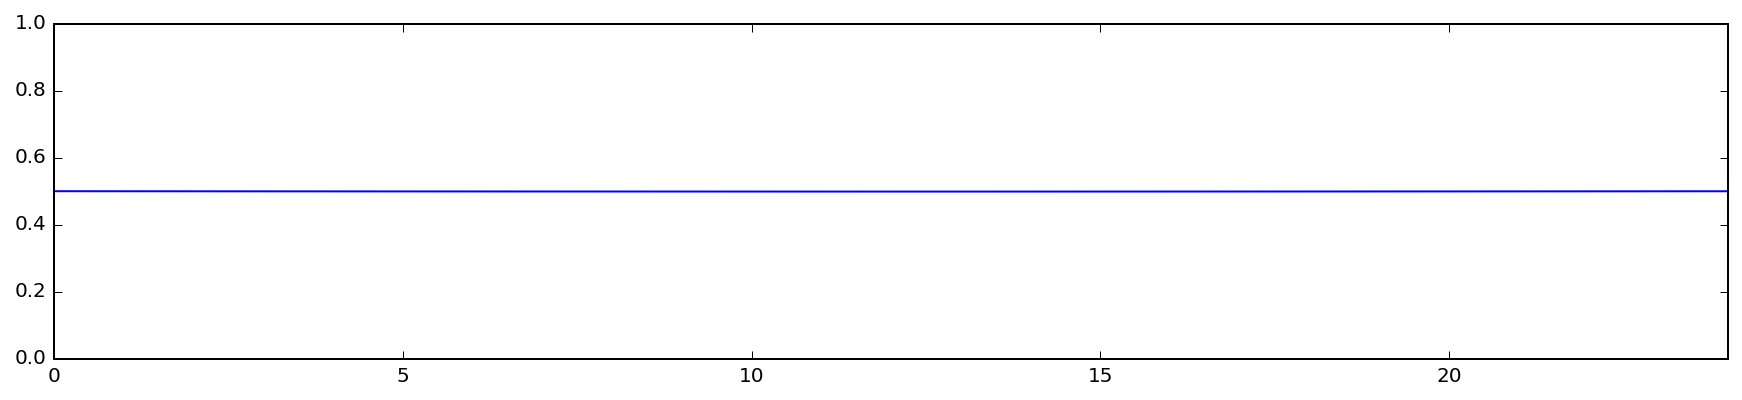

In [112]:
vague_animate(vague_solo, x_offset=vague_solo.shape[0]//2-25//2, y_offset=vague_solo.shape[1]//2, t_offset=vague_solo.shape[-1]//4, N_steps=vague_solo.shape[-1]//2)

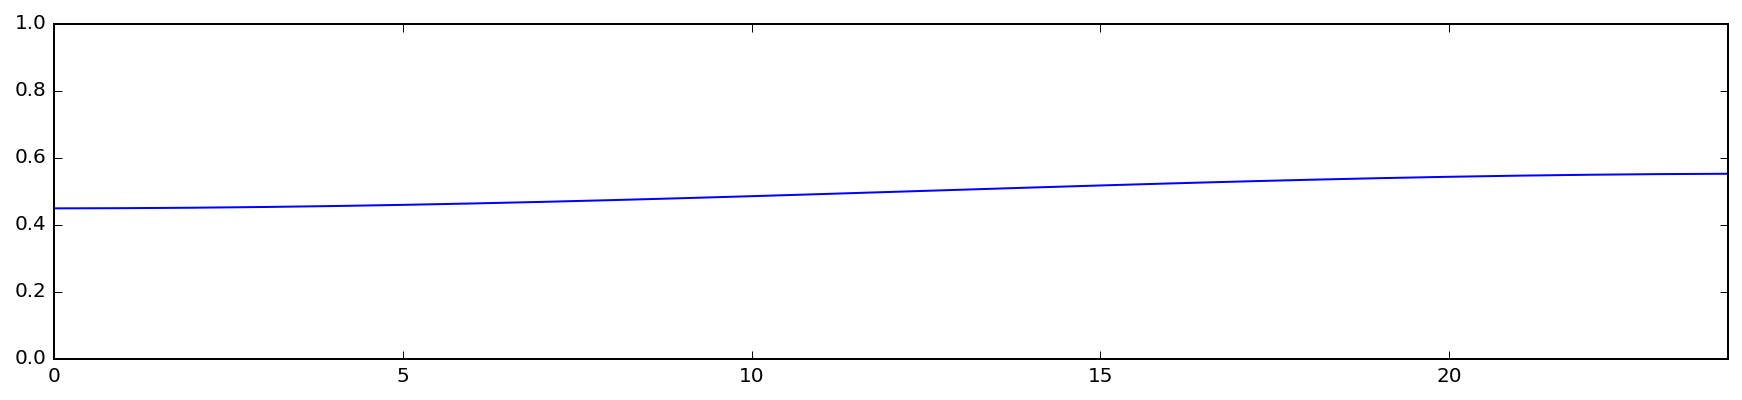

In [113]:
vague_animate(vague_solo, x_offset=vague_solo.shape[0]//2-25//2, y_offset=vague_solo.shape[1]//2, 
              t_offset=vague_solo.shape[-1]*3//8, N_steps=vague_solo.shape[-1]//4)

## Saving as a scenario

In [114]:
%%writefile ../scenario_line_onde.py
#!/usr/bin/env python
# -*- coding: utf8 -*-

import elasticite as el
import numpy as np

def make_vague(impulse=False):
    import os
    import numpy as np
    import MotionClouds as mc

    mc.N_X, mc.N_Y, mc.N_frame = 50, 2, 2048
    fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
    theta, B_theta = 0., np.pi/8.
    alpha, sf_0, B_sf, B_V = 1., .02, .1, .1
    seed = 1234565
    V_X, V_Y = .1, 0.
    mc_wave = mc.envelope_gabor(fx, fy, ft, V_X=V_X, V_Y=V_Y, B_V=B_V, 
                                theta=theta, B_theta=B_theta, sf_0=sf_0, B_sf=B_sf, alpha=alpha)

    wave = mc.random_cloud(mc_wave, seed=seed, impulse=impulse)
    
    wave -= wave.mean()
    wave /= np.abs(wave).max()
    return wave

class EdgeGrid(el.EdgeGrid):
    def __init__(self, vague, x_offset=0, y_offset=0, t_offset=0, N_steps = 2048, damp_tau=5., **kwargs):
        #super(el.EdgeGrid.__init__(self))
        #super(el.EdgeGrid, self).__init__(**kwargs)
        el.EdgeGrid.__init__(self, **kwargs)
        #print (self.verb, kwargs)
        self.vague = vague
        self.x_offset = x_offset
        self.y_offset = y_offset
        self.t_offset = t_offset
        self.N_steps = N_steps
        #print(self.x_offset, self.y_offset, self.t_offset)
        #print(self.z.shape)
        self.damp_tau = damp_tau
        
        
    def update(self):
        if self.structure: N_lame = self.N_lame-self.struct_N
        else: N_lame = self.N_lame
        damp = lambda t: 1. - np.exp(-np.abs(np.mod(t+self.period/2, self.period)-self.period/2)/self.damp_tau)

        N_periods = 1
        i = np.mod(np.int(self.t/self.period * self.vague.shape[2] / N_periods), self.vague.shape[2])
        surface = np.zeros_like(self.lames[2, :N_lame])
        #for k, amp in zip([-2, -1, 0, 1, 2], [.125, .25, .5, .25, .125]):
        #    surface += amp * self.vague[self.x_offset:(self.x_offset+N_lame), self.y_offset, self.t_offset+i+k]
        surface = self.vague[self.x_offset:(self.x_offset+N_lame), self.y_offset, self.t_offset+i].ravel()
        #surface = np.convolve(surface, np.arange(5), mode='same')
        #dsurface = np.gradient(surface)
        #dsurface = np.roll(surface, 1) - surface
        #dsurface *= np.bartlett(N_lame)
        # print(dsurface.mean(), np.abs(dsurface).max(), damp(self.t))
        #dsurface /= np.abs(dsurface).max()
        surface *= np.tan(np.pi/12)*damp(self.t) # maximum angle achieved
        #print(surface.min(), surface.mean(), np.abs(surface).max(), damp(self.t))
        self.lames[2, :N_lame] = np.arctan(surface)
        
if __name__ == "__main__":
    import sys
    if len(sys.argv)>1: mode = sys.argv[1]
    else: mode = 'both'
        
    vague_dense = make_vague(impulse=False)
    print (np.abs(vague_dense).max())

    period = 2048./30
    e = EdgeGrid(N_lame=25, grid_type='line', mode=mode,
                 verb=False, period=period, filename='mat/line_onde_dense.npy', 
                 vague = vague_dense,
                 x_offset=0, y_offset=0, t_offset=0, N_steps=2048)

    # running the code
    el.main(e)


Overwriting ../scenario_line_onde.py


In [115]:
%cd ..
!rm mat/line_onde_dense.npy
%run  scenario_line_onde.py writer
%cd posts

/Users/laurentperrinet/cloud_nas/science/elasticte
1.0
/Users/laurentperrinet/cloud_nas/science/elasticte/posts


[autoreload of scenario_line_onde failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: 'NoneType' object has no attribute 'name'
]


(2048, 26)


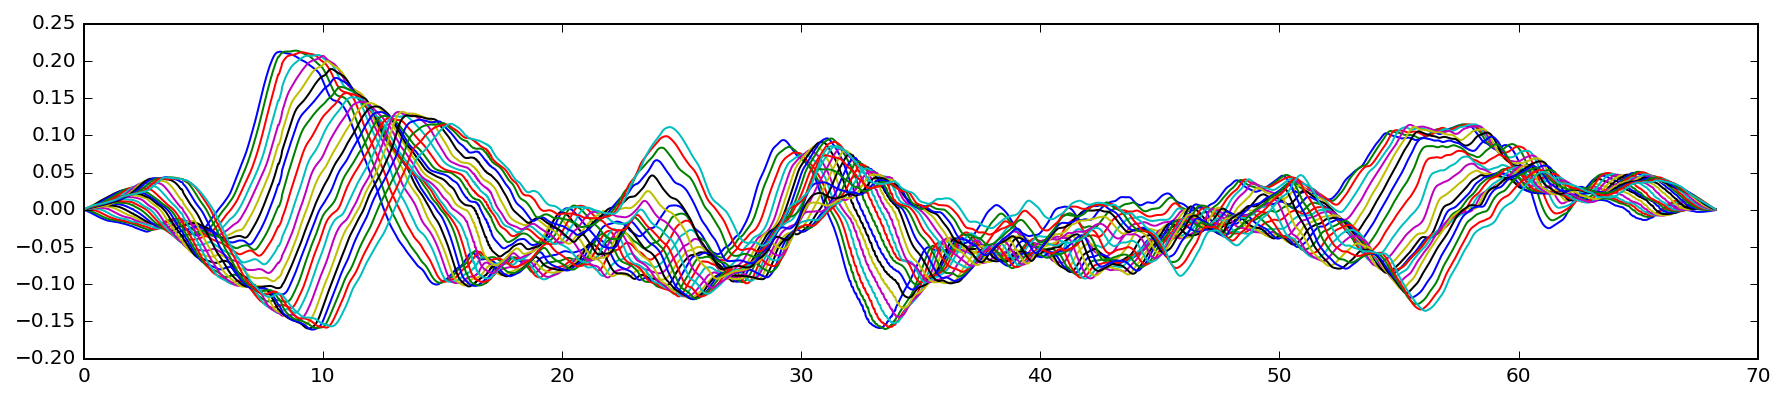

In [116]:
z = np.load('../mat/line_onde_dense.npy')
print(z.shape)
fig, ax = plt.subplots(figsize=(15, 3))
#_ = ax.plot(z[:, 0])
_ = ax.plot(z[:, 0], z[:, 1:])

In [117]:
%%writefile ../scenario_line_onde_solo.py
#!/usr/bin/env python
# -*- coding: utf8 -*-

import elasticite as el
import numpy as np

from scenario_line_onde import make_vague, EdgeGrid

if __name__ == "__main__":
    import sys
    if len(sys.argv)>1: mode = sys.argv[1]
    else: mode = 'both'
    period = 2048./30
    vague_solo = make_vague(impulse=True)
    e_solo = EdgeGrid(N_lame=25, grid_type='line', mode=mode,
                 verb=False, period=period, filename='mat/line_onde_solo.npy', 
                 vague = vague_solo,
                 x_offset=vague_solo.shape[0]//2-25//2, y_offset=vague_solo.shape[1]//2, 
                 t_offset=0, N_steps=512)#t_offset=vague_solo.shape[-1]*3//8, N_steps=vague_solo.shape[-1]//4)

    # running the code
    el.main(e_solo)

Overwriting ../scenario_line_onde_solo.py


In [118]:
%cd ..
!rm mat/line_onde_solo.npy
%run  scenario_line_onde_solo.py writer
%cd posts

/Users/laurentperrinet/cloud_nas/science/elasticte
/Users/laurentperrinet/cloud_nas/science/elasticte/posts


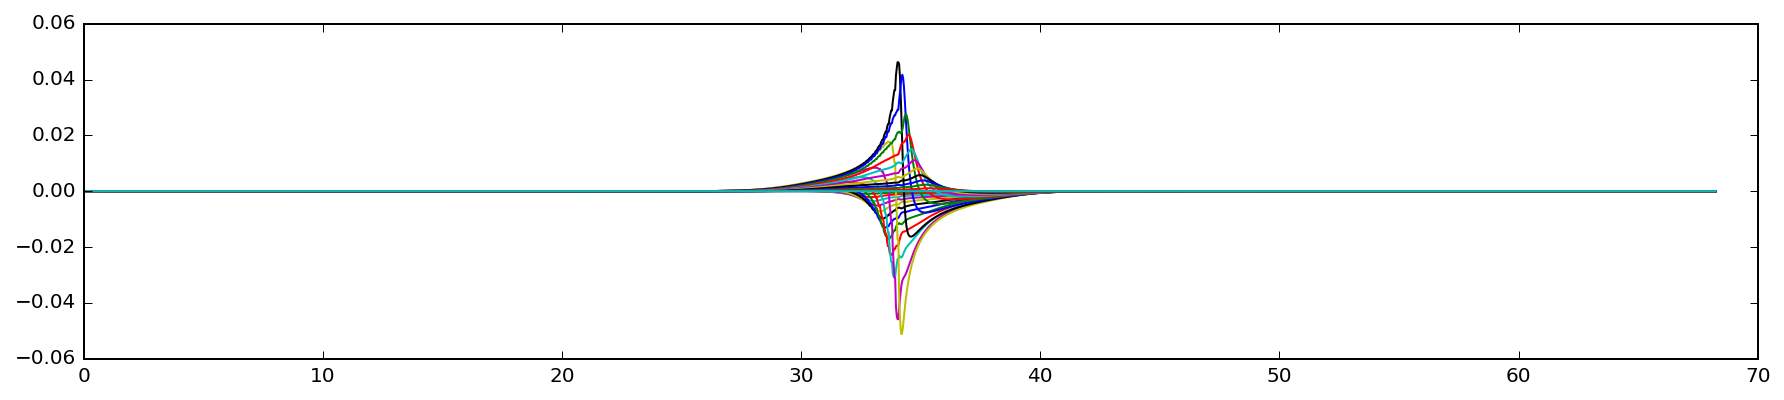

In [119]:
z = np.load('../mat/line_onde_solo.npy')
fig, ax = plt.subplots(figsize=(15, 3))
#_ = ax.plot(z[:, 0])
_ = ax.plot(z[:, 0], z[:, 1:])

## git


In [120]:
!git pull

Already up-to-date.


In [121]:
!git add ../mat/line_onde_* ../scenario_line_onde*
!git s

M  ../mat/line_onde_dense.npy
 M ../mat/master.npy
 M "2015-11-26 \303\251lasticit\303\251 - sc\303\251nario montage.ipynb"
 M "2015-11-27 \303\251lasticit\303\251, geometrie.ipynb"
 M "2015-11-29 \303\251lasticit\303\251 - sc\303\251nario onde.ipynb"
 M ../scenario_line_master.py
M  ../scenario_line_onde.py
 M ../src/elasticite.py


In [122]:
!git commit -am' scenario onde '

[master 8c84d27]  scenario onde
 8 files changed, 14602 insertions(+), 28357 deletions(-)
 rewrite mat/line_onde_dense.npy (94%)
 rewrite "posts/2015-11-27 \303\251lasticit\303\251, geometrie.ipynb" (94%)
 rewrite "posts/2015-11-29 \303\251lasticit\303\251 - sc\303\251nario onde.ipynb" (83%)


In [123]:
! git push


Counting objects: 13, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (13/13), done.
Writing objects: 100% (13/13), 14.96 MiB | 10.73 MiB/s, done.
Total 13 (delta 7), reused 0 (delta 0)
To git@git.framasoft.org:laurentperrinet/elasticte.git
   ca352a4..8c84d27  master -> master
